In [141]:
import pandas as pd
import numpy as np
from brokenaxes import brokenaxes

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 30})

In [3]:
header = [np.array(['partitioning', 'cfg', 'univmon', 'univmon', 'univmon_greedy', 
                    'univmon_greedy', 'univmon_greedy_rows', 'univmon_greedy_rows', 
                    'netmon', 'netmon']), 
         np.array(['', '', 'throughput', 'resources', 'throughput', 'resources', 
                   'throughput', 'resources', 'throughput', 'resources'])]
solvers = ['univmon', 'univmon_greedy', 'univmon_greedy_rows', 'netmon']

def get_df(file_path, hdr=header):
    df = pd.read_csv(file_path, header=None)
    df = df.drop(df.columns[-1], axis=1)
    df.columns = hdr
    df = df.replace(' -', np.nan)
    df['univmon'] = df['univmon'].astype('float')
    return df

In [ ]:
def scatter_thr_resources(df, selection = [3, 9]):
    markers = ['o', 'x', 's', 'v']
    plt.figure(figsize=(15, 10))
    idx = 0
    for solver in solvers:
        plt.scatter(df[solver]['resources'][df['cfg'].isin(selection)], 
                    df[solver]['throughput'][df['cfg'].isin(selection)],
                    label=solver, marker=markers[idx])
        idx += 1

    plt.legend()
    plt.ylabel('Throughput (Mpps)')
    plt.xlabel('Resources')
    plt.show()

In [ ]:
def thr(df):
    plt.figure(figsize=(20, 10))
    for solver in solvers:
        plt.plot(df.index, df[solver]['throughput'], label=solver)

    plt.ylabel('Throughput (Mpps)')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()

In [ ]:
def res(df):
    plt.figure(figsize=(20, 10))
    for solver in solvers:
        plt.plot(df.index, df[solver]['resources'], label=solver)

    plt.ylabel('Resources')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()

In [ ]:
def partition_sensitivity(df):
    pars = ['h', 'v', 'hv', 'n']
    plt.figure(figsize=(15, 10))
    for par in pars:
        ys = df['univmon']['throughput'][df['partitioning'] == par]
        for solver in solvers[1:]:
            ys.append(df[solver]['throughput'][df['partitioning'] == par])

        xs = df['univmon']['resources'][df['partitioning'] == par]
        for solver in solvers[1:]:
            ys.append(df[solver]['resources'][df['partitioning'] == par])

        plt.scatter(xs, ys, label=par)

    plt.ylabel('Throughput (Mpps)')
    plt.xlabel('Resources')
    plt.legend()
    plt.show()

In [ ]:
df = get_df("../outputs/1_first_run/sensitivity.csv")
plotters = [scatter_thr_resources, thr, res, partition_sensitivity]

for plotter in plotters:
    plotter(df)

In [ ]:
df2 = get_df("../outputs/2_modify_univmon_objective/sensitivity2.csv")

for plotter in plotters:
    plotter(df2)

In [ ]:
df2 = get_df("../outputs/3_make_partitioning_parameter/sensitivity3.csv")

for plotter in plotters:
    plotter(df2)

In [ ]:
df2 = get_df("../outputs/4_mem_eq_with_tol/sensitivity4.csv")

for plotter in plotters:
    plotter(df2)

In [ ]:
df = get_df("../outputs/4_mem_eq_with_tol/selected.csv")

In [63]:
vals = 6
solvers = ['univmon', 'univmon_greedy', 'univmon_greedy_rows', 'netmon']
num_solvers = len(solvers)
mylabels = {
    'univmon': 'memory-aware',
    'univmon_greedy': 'greedy-mem-SW-over-CPU',
    'univmon_greedy_rows': 'greedy-compute-SW-over-CPU',
    'netmon': 'our-approach'
}
hdr = [np.array(['partitioning', 'cfg'] + ['univmon'] * vals + ['univmon_greedy'] * vals
                 + ['univmon_greedy_rows'] * vals + ['netmon'] * vals), 
         np.array(['', ''] + ['throughput', 'resources', 'cores', 'total_cpus', 'switch_memory', 'time'] * num_solvers)]
df = get_df("../outputs/poster2-sel.csv", hdr)

In [109]:
def plot_bar(df, param='resources', ylabel='Resources', broken=False, show=False, use_int=False):
    
    labels = ['C{}'.format(x + 1) for x in range(len(df))]
    x = np.arange(len(labels))
    width = 0.22
    idx = 0
    if(broken):
        fig = plt.figure(figsize=(20, 5))
        ax = brokenaxes(ylims=((0, 1000), (7500, 8500), (9500, 10000)), hspace=.05)
    else:
        fig, ax = plt.subplots()
        fig.set_size_inches(20, 8)
    rects = {}
    for solver in solvers:

        vec = df[solver][param]
        vec = df[solver][param]
        rects[idx] = ax.bar(x + (idx-1.5) * width, vec, width, label=mylabels[solver])
        idx+=1
    
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Configuration (Topology and queries)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    #ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if(use_int):
                try:
                    ax.annotate('{}'.format(int(height)),
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')
                except:
                    pass
            else:
                 ax.annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    if(show):
        for idx in range(len(solvers)):
             autolabel(rects[idx])

    if not broken:
        fig.tight_layout()
    return ax

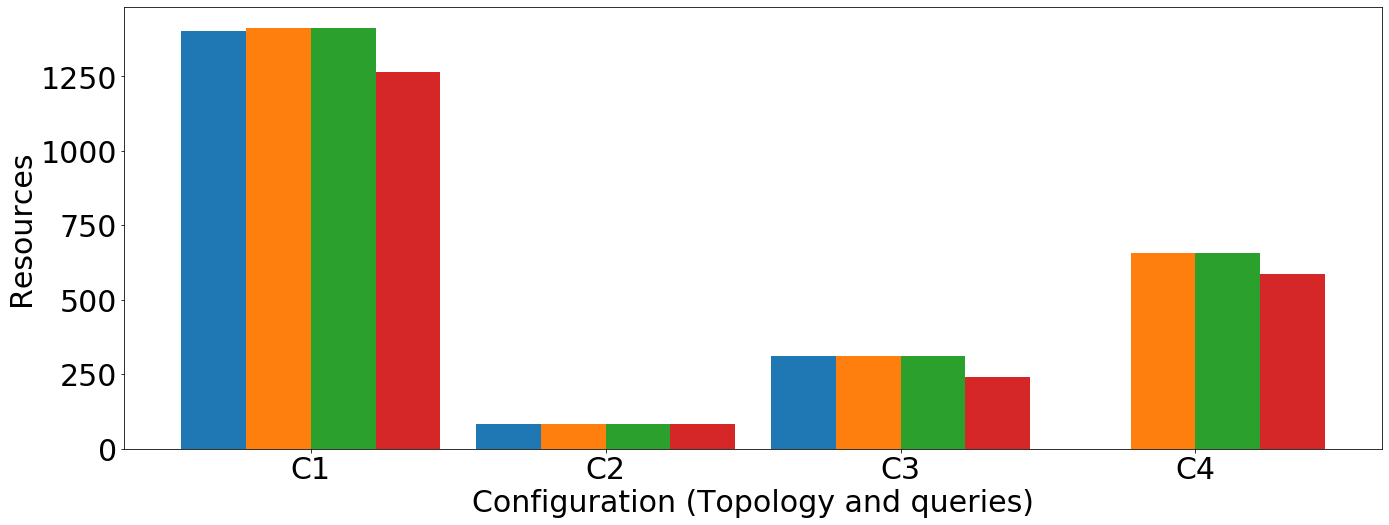

In [107]:
plot_bar(df)

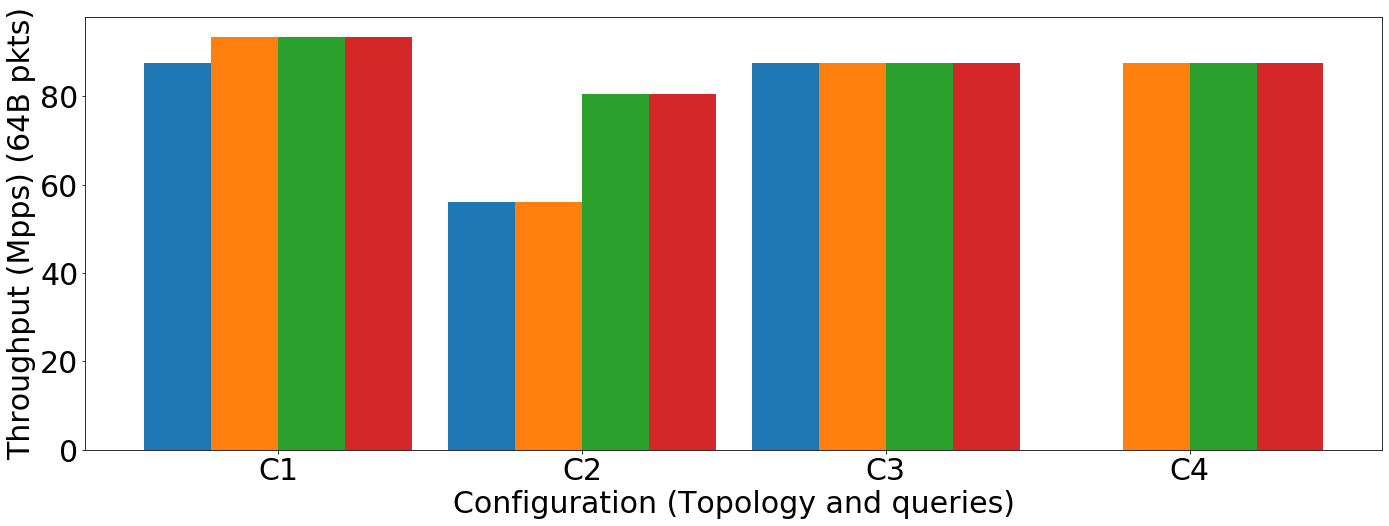

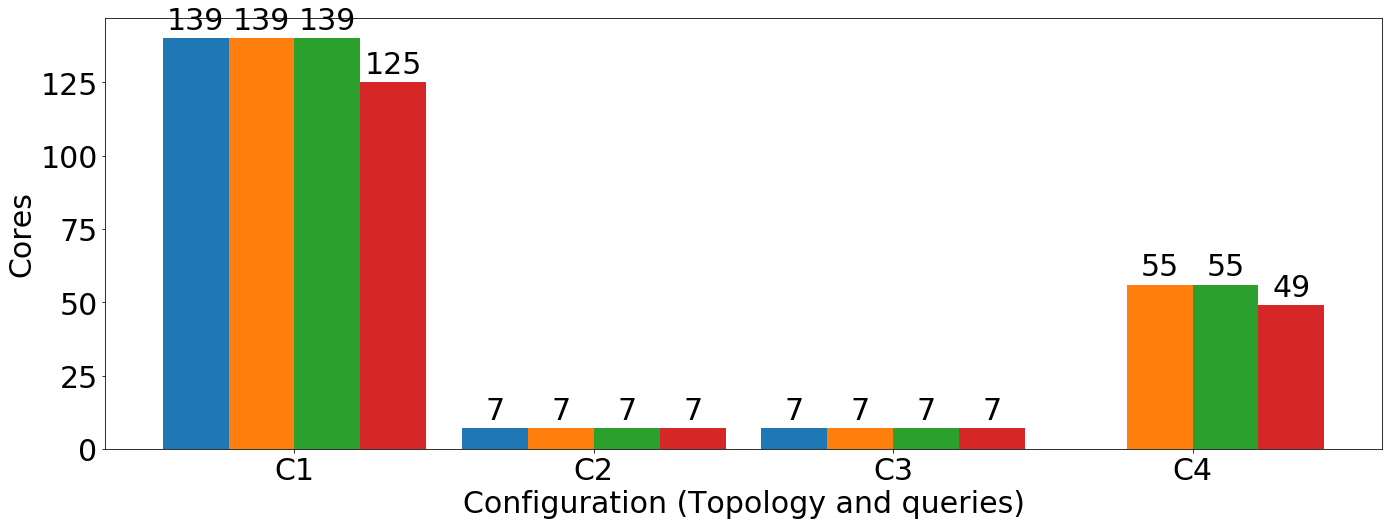

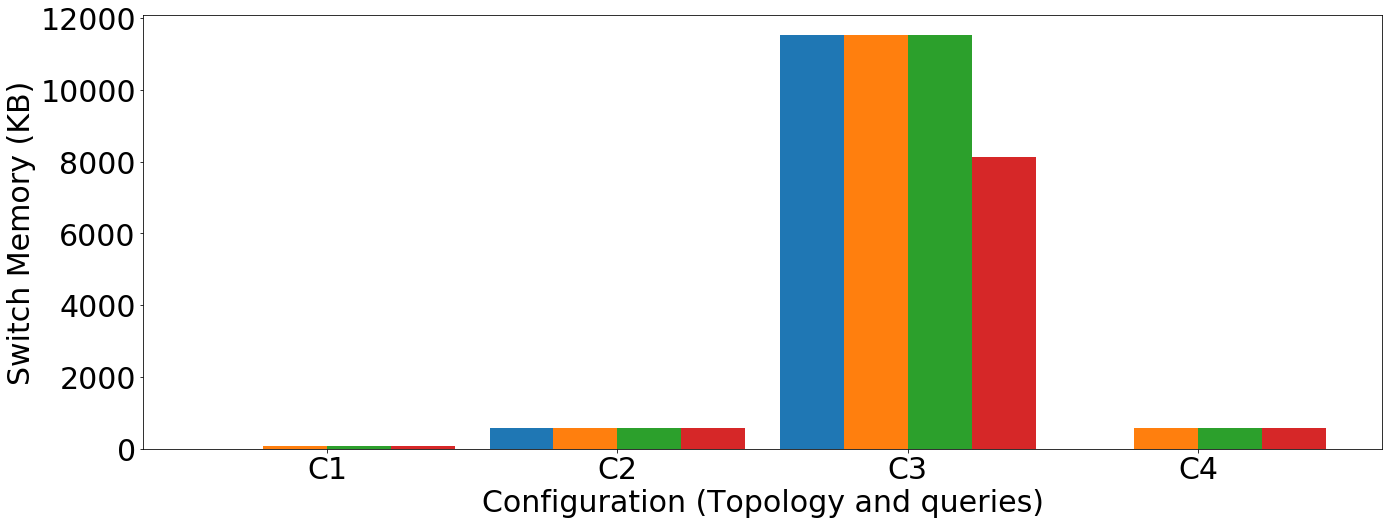

In [110]:
ax = plot_bar(df, 'throughput', 'Throughput (Mpps) (64B pkts)')
plot_bar(df, 'cores', 'Cores', show=True, use_int=True)
plot_bar(df, 'switch_memory', 'Switch Memory (KB)')

/home/anup/miniconda3/envs/wbase/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


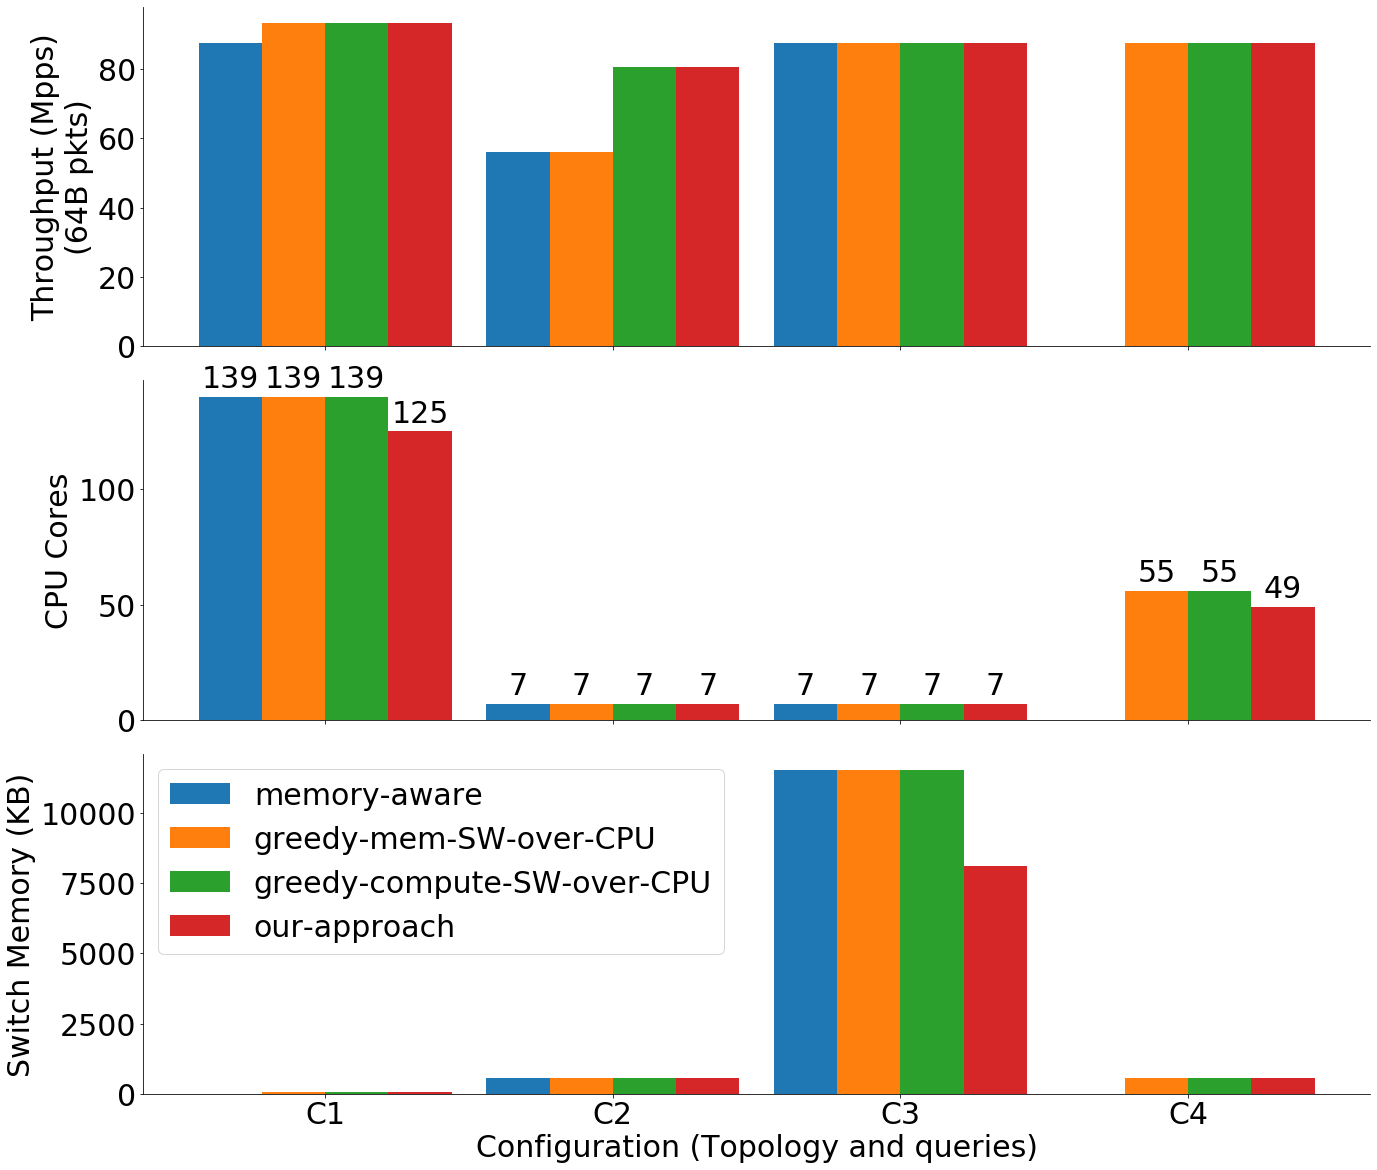

In [152]:
param = 'throughput'
ylabel= 'Throughput (Mpps)\n(64B pkts)'

fig = plt.figure(figsize=(22, 20))
gs = gridspec.GridSpec(3, 1)
gs.update(wspace=0.1, hspace=0.1)

ax = plt.subplot(gs[0])
#fig.set_size_inches(20, 8)
rects = {}
idx = 0
for solver in solvers:

    vec = df[solver][param]
    vec = df[solver][param]
    rects[idx] = ax.bar(x + (idx-1.5) * width, vec, width, label=mylabels[solver])
    idx+=1

ax.set_ylabel(ylabel)
#ax.set_xlabel('Configuration (Topology and queries)')
#ax.set_xticks(x)
#ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), visible=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

param = 'cores'
ylabel= 'CPU Cores'

ax1 = plt.subplot(gs[1], sharex=ax)
rects = {}
idx = 0
for solver in solvers:

    vec = df[solver][param]
    vec = df[solver][param]
    rects[idx] = ax1.bar(x + (idx-1.5) * width, vec, width, label=mylabels[solver])
    idx+=1

ax1.set_ylabel(ylabel)
#ax1.set_xlabel('Configuration (Topology and queries)')
#ax1.set_xticks(x)
#ax1.set_xticklabels(labels)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        try:
            ax1.annotate('{}'.format(int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        except:
            pass

for idx in range(len(solvers)):
     autolabel(rects[idx])

param = 'switch_memory'
ylabel= 'Switch Memory (KB)'

ax1 = plt.subplot(gs[2], sharex=ax)
rects = {}
idx = 0
for solver in solvers:

    vec = df[solver][param]
    vec = df[solver][param]
    rects[idx] = ax1.bar(x + (idx-1.5) * width, vec, width, label=mylabels[solver])
    idx+=1

ax1.set_ylabel(ylabel)
ax1.set_xlabel('Configuration (Topology and queries)')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

fig.tight_layout()

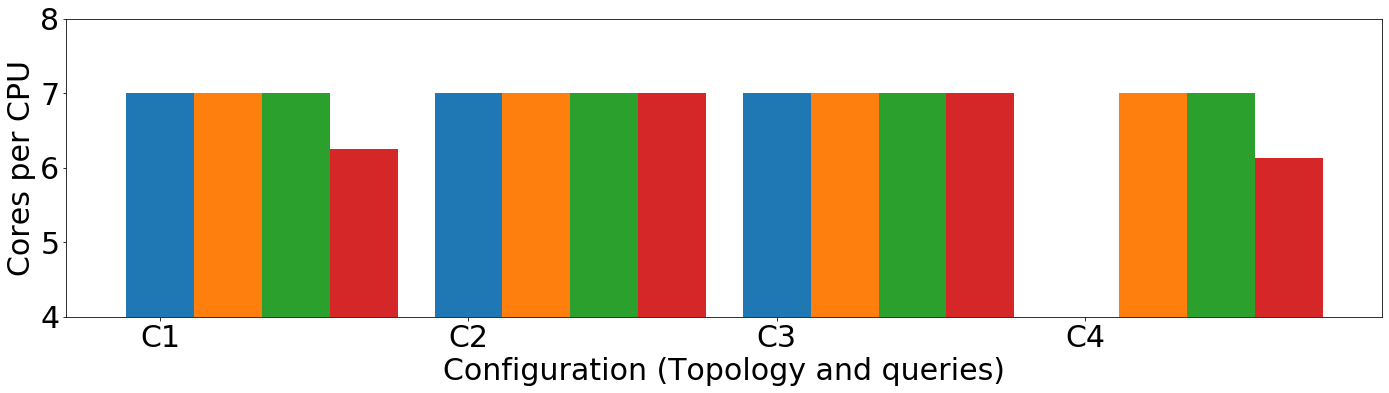

In [69]:
labels = ['C{}'.format(x + 1) for x in range(len(df))]
x = np.arange(len(labels))
width = 0.22
idx = 0
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
rects = {}
for solver in solvers:

    vec = df[solver]['cores'] / df[solver]['total_cpus']
    rects[idx] = ax.bar(x + idx * width, vec, width, label=mylabels[solver])
    idx+=1

ax.set_ylabel("Cores per CPU")
ax.set_xlabel('Configuration (Topology and queries)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.legend()

# for idx in range(len(labels)):
#     autolabel(rects[idx])

fig.tight_layout()
plt.ylim((4, 8))
plt.show()